In [1]:
# Importing the necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import time
import copy
import pandas as pd
from PIL import Image
from torchvision import datasets, models, transforms

In [2]:
# Defining the needed parameters

dataset_dir = '../Dataset'
model_name = 'alexnet'
num_classes = 15
batch_size = 128
num_epochs = 500
feature_extract = True

In [3]:
# Loading the data

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [4]:
# Detecting GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# Getting the GPU name

torch.cuda.get_device_name(0)

'GeForce 840M'

In [6]:
# Reshaping and initializing the model

def initialize_alexnet(model_name, num_classes, feature_extract=True, use_pretrained=True):

  model_ft = None
  input_size = 0

  if model_name == "alexnet":
    model_ft = models.alexnet(pretrained=use_pretrained)

    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False
    
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    input_size = 224
  else:
        print("Model name is invalid!")
        exit()

  return model_ft,input_size

model_ft, input_size = initialize_alexnet(model_name, num_classes, feature_extract)

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# Creating the optimizer

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Parameters to learn")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)

Parameters to learn
	 classifier.6.weight
	 classifier.6.bias


In [8]:
# Training the model

def train_model(model, dataloaders, criterion, optimizer, num_epochs=500):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch: {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else: 
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('-' * 35)
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    print('-' * 35)

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

criterion = nn.CrossEntropyLoss()

model_ft, val_acc_hist, train_acc_hist, val_loss_hist, train_loss_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch: 1/500
------------------------------
train Loss: 1.1591 Acc: 0.6518
val Loss: 1.2635 Acc: 0.6865

Epoch: 2/500
------------------------------
train Loss: 1.0514 Acc: 0.7029
val Loss: 0.6622 Acc: 0.8043

Epoch: 3/500
------------------------------
train Loss: 0.9568 Acc: 0.7248
val Loss: 1.0141 Acc: 0.7443

Epoch: 4/500
------------------------------
train Loss: 1.0119 Acc: 0.7185
val Loss: 0.8385 Acc: 0.8290

Epoch: 5/500
------------------------------
train Loss: 0.9391 Acc: 0.7377
val Loss: 0.5391 Acc: 0.8496

Epoch: 6/500
------------------------------
train Loss: 0.9293 Acc: 0.7356
val Loss: 1.0069 Acc: 0.7633

Epoch: 7/500
------------------------------
train Loss: 0.8951 Acc: 0.7473
val Loss: 0.5961 Acc: 0.8474

Epoch: 8/500
------------------------------
train Loss: 0.9033 Acc: 0.7503
val Loss: 0.5894 Acc: 0.8553

Epoch: 9/500
------------------------------
train Loss: 0.9888 Acc: 0.7383
val Loss: 0.8122 Acc: 0.7922

Epoch: 10/500
------------------------------
train Loss

train Loss: 0.8441 Acc: 0.7690
val Loss: 0.8614 Acc: 0.8059

Epoch: 79/500
------------------------------
train Loss: 0.8360 Acc: 0.7772
val Loss: 0.6146 Acc: 0.8348

Epoch: 80/500
------------------------------
train Loss: 0.8093 Acc: 0.7812
val Loss: 0.5952 Acc: 0.8532

Epoch: 81/500
------------------------------
train Loss: 0.8101 Acc: 0.7818
val Loss: 0.7817 Acc: 0.8353

Epoch: 82/500
------------------------------
train Loss: 0.8457 Acc: 0.7768
val Loss: 0.6897 Acc: 0.8427

Epoch: 83/500
------------------------------
train Loss: 0.8366 Acc: 0.7765
val Loss: 0.5673 Acc: 0.8490

Epoch: 84/500
------------------------------
train Loss: 0.8670 Acc: 0.7734
val Loss: 0.6724 Acc: 0.8480

Epoch: 85/500
------------------------------
train Loss: 0.8553 Acc: 0.7730
val Loss: 0.6321 Acc: 0.8406

Epoch: 86/500
------------------------------
train Loss: 0.8420 Acc: 0.7760
val Loss: 0.7474 Acc: 0.8159

Epoch: 87/500
------------------------------
train Loss: 0.8003 Acc: 0.7829
val Loss: 0.581

train Loss: 0.8124 Acc: 0.7842
val Loss: 0.4604 Acc: 0.8748

Epoch: 156/500
------------------------------
train Loss: 0.8333 Acc: 0.7766
val Loss: 0.5406 Acc: 0.8664

Epoch: 157/500
------------------------------
train Loss: 0.8338 Acc: 0.7778
val Loss: 0.5237 Acc: 0.8738

Epoch: 158/500
------------------------------
train Loss: 0.8080 Acc: 0.7804
val Loss: 0.6559 Acc: 0.8390

Epoch: 159/500
------------------------------
train Loss: 0.8757 Acc: 0.7712
val Loss: 0.8872 Acc: 0.8148

Epoch: 160/500
------------------------------
train Loss: 0.8111 Acc: 0.7823
val Loss: 0.6850 Acc: 0.8396

Epoch: 161/500
------------------------------
train Loss: 0.9116 Acc: 0.7678
val Loss: 0.5909 Acc: 0.8532

Epoch: 162/500
------------------------------
train Loss: 0.8352 Acc: 0.7786
val Loss: 0.7207 Acc: 0.8396

Epoch: 163/500
------------------------------
train Loss: 0.8191 Acc: 0.7821
val Loss: 0.5443 Acc: 0.8627

Epoch: 164/500
------------------------------
train Loss: 0.8127 Acc: 0.7820
val Lo

train Loss: 0.8131 Acc: 0.7820
val Loss: 0.8071 Acc: 0.8243

Epoch: 233/500
------------------------------
train Loss: 0.8174 Acc: 0.7847
val Loss: 0.6892 Acc: 0.8338

Epoch: 234/500
------------------------------
train Loss: 0.8373 Acc: 0.7770
val Loss: 0.8149 Acc: 0.8254

Epoch: 235/500
------------------------------
train Loss: 0.8510 Acc: 0.7751
val Loss: 0.6422 Acc: 0.8543

Epoch: 236/500
------------------------------
train Loss: 0.8097 Acc: 0.7839
val Loss: 0.9271 Acc: 0.8138

Epoch: 237/500
------------------------------
train Loss: 0.8524 Acc: 0.7796
val Loss: 0.9719 Acc: 0.8022

Epoch: 238/500
------------------------------
train Loss: 0.8347 Acc: 0.7829
val Loss: 0.4929 Acc: 0.8685

Epoch: 239/500
------------------------------
train Loss: 0.7929 Acc: 0.7841
val Loss: 0.5665 Acc: 0.8564

Epoch: 240/500
------------------------------
train Loss: 0.8111 Acc: 0.7833
val Loss: 0.8958 Acc: 0.8169

Epoch: 241/500
------------------------------
train Loss: 0.8906 Acc: 0.7738
val Lo

train Loss: 0.8233 Acc: 0.7812
val Loss: 0.5587 Acc: 0.8638

Epoch: 310/500
------------------------------
train Loss: 0.7993 Acc: 0.7877
val Loss: 0.5277 Acc: 0.8722

Epoch: 311/500
------------------------------
train Loss: 0.7882 Acc: 0.7886
val Loss: 0.7379 Acc: 0.8396

Epoch: 312/500
------------------------------
train Loss: 0.8010 Acc: 0.7898
val Loss: 0.5025 Acc: 0.8611

Epoch: 313/500
------------------------------
train Loss: 0.8125 Acc: 0.7845
val Loss: 1.0264 Acc: 0.8048

Epoch: 314/500
------------------------------
train Loss: 0.8436 Acc: 0.7803
val Loss: 0.8512 Acc: 0.8190

Epoch: 315/500
------------------------------
train Loss: 0.7954 Acc: 0.7888
val Loss: 0.5749 Acc: 0.8632

Epoch: 316/500
------------------------------
train Loss: 0.8285 Acc: 0.7791
val Loss: 0.6077 Acc: 0.8632

Epoch: 317/500
------------------------------
train Loss: 0.8055 Acc: 0.7860
val Loss: 0.6733 Acc: 0.8332

Epoch: 318/500
------------------------------
train Loss: 0.8071 Acc: 0.7874
val Lo

train Loss: 0.8148 Acc: 0.7829
val Loss: 0.7334 Acc: 0.8301

Epoch: 387/500
------------------------------
train Loss: 0.8240 Acc: 0.7803
val Loss: 0.5333 Acc: 0.8790

Epoch: 388/500
------------------------------
train Loss: 0.8009 Acc: 0.7850
val Loss: 0.8460 Acc: 0.8311

Epoch: 389/500
------------------------------
train Loss: 0.7981 Acc: 0.7883
val Loss: 0.6253 Acc: 0.8490

Epoch: 390/500
------------------------------
train Loss: 0.8292 Acc: 0.7832
val Loss: 0.7576 Acc: 0.8269

Epoch: 391/500
------------------------------
train Loss: 0.8388 Acc: 0.7825
val Loss: 0.9046 Acc: 0.8054

Epoch: 392/500
------------------------------
train Loss: 0.8237 Acc: 0.7874
val Loss: 0.8365 Acc: 0.8264

Epoch: 393/500
------------------------------
train Loss: 0.7818 Acc: 0.7908
val Loss: 0.5652 Acc: 0.8595

Epoch: 394/500
------------------------------
train Loss: 0.8372 Acc: 0.7831
val Loss: 0.6892 Acc: 0.8501

Epoch: 395/500
------------------------------
train Loss: 0.8172 Acc: 0.7807
val Lo

train Loss: 0.8380 Acc: 0.7827
val Loss: 0.8755 Acc: 0.8296

Epoch: 464/500
------------------------------
train Loss: 0.8013 Acc: 0.7915
val Loss: 0.6307 Acc: 0.8453

Epoch: 465/500
------------------------------
train Loss: 0.7850 Acc: 0.7880
val Loss: 0.7033 Acc: 0.8322

Epoch: 466/500
------------------------------
train Loss: 0.7980 Acc: 0.7862
val Loss: 0.7454 Acc: 0.8369

Epoch: 467/500
------------------------------
train Loss: 0.8122 Acc: 0.7845
val Loss: 0.6419 Acc: 0.8406

Epoch: 468/500
------------------------------
train Loss: 0.8112 Acc: 0.7869
val Loss: 0.7957 Acc: 0.8264

Epoch: 469/500
------------------------------
train Loss: 0.7961 Acc: 0.7860
val Loss: 0.7907 Acc: 0.8369

Epoch: 470/500
------------------------------
train Loss: 0.8181 Acc: 0.7818
val Loss: 0.7050 Acc: 0.8453

Epoch: 471/500
------------------------------
train Loss: 0.8485 Acc: 0.7828
val Loss: 0.7732 Acc: 0.8264

Epoch: 472/500
------------------------------
train Loss: 0.7868 Acc: 0.7888
val Lo

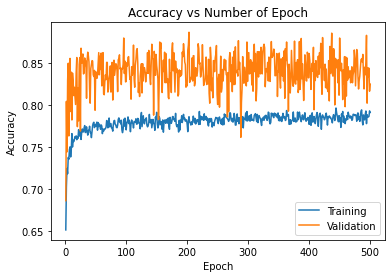

In [9]:
# Getting the learning process history in graph

plt.title("Accuracy vs Number of Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),train_acc_hist,label="Training")
plt.plot(range(1,num_epochs+1),val_acc_hist,label="Validation")
plt.xticks(np.arange(0, num_epochs+1, 100))
plt.legend()
plt.show()

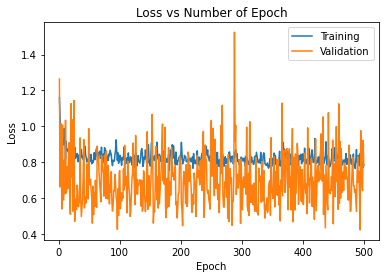

In [10]:
# Getting the learning process history in graph

plt.title("Loss vs Number of Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),train_loss_hist,label="Training")
plt.plot(range(1,num_epochs+1),val_loss_hist,label="Validation")
plt.xticks(np.arange(0, num_epochs+1, 100))
plt.legend()
plt.show()

In [11]:
# Saving the model

model_path = '../Model/Pesticides_Prescription_Model.sav'
torch.save(model_ft.state_dict(), model_path)

In [12]:
# Saving the class labels

class_labels_path = '../Model/Class_Labels_Pesticides_Prescription_Model.csv'

def save_class_labels(class_labels_path):
    labels_dict = image_datasets['train'].class_to_idx
    labels_df = pd.DataFrame.from_dict(data=labels_dict, orient='index', columns=['idx'])
    labels_df['Label'] = labels_df.index
    labels_df.reset_index(drop=True, inplace=True)
    labels_df.to_csv(class_labels_path, header=None, index=False)

save_class_labels(class_labels_path)